In [1]:
import stanza
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import jsonlines
import json
import gzip
import numpy as np
import math
from tqdm import tqdm
import os
from tqdm import tqdm
import pickle

## 1) Load Dataset
Load and preprocess dataset

In [ ]:
rawdata = jsonlines.Reader(gzip.open('guesswhat.valid.jsonl.gz'))
questions = ""
for game in rawdata:
    for qa in game['qas']:
        questions += qa['question'] + '\n'
        
fname = 'guesswhat.valid.raw.txt'
if not os.path.exists(fname):
    with open(fname, 'w') as fl:
        fl.write(questions)

In [ ]:
stanza.download('en')
nlp = stanza.Pipeline('en')

In [ ]:
fname = 'guesswhat.valid.raw.txt'
with open(fname) as fl:
    questions = fl.read().split('\n')
questions = np.asarray(questions)

In [ ]:
# Batch of questions to pass through Stanza
batch_size = 256

complete_doc = []
total_batches = math.ceil(len(questions)/batch_size)
for b in tqdm(range(total_batches)):
    # I actually forgot how to batch correctly. So... here it is.
    # Please forgive me.
    if b == total_batches -1:
        sample = questions[b*batch_size:] 
    else:
        sample = questions[b*batch_size: (b+1)*batch_size] 

    # Form the batch for Stanza separated by \n\n
    allqs = ''
    for q in sample:
        allqs += q
        allqs += '\n\n'
    allqs = allqs.lower().strip()

    # Get classifications for all questions in allqs
    doc = nlp(allqs)
    complete_doc += doc.to_dict()
    
complete_doc = stanza.Document(complete_doc)
doc_fname = 'guesswhat.valid.doc.json'
with open(doc_fname, 'w') as fl:
    json.dump(complete_doc.to_dict(), fl)

## 2) Stanza Stuff

In [2]:
doc_fname = 'guesswhat.valid.doc.json'
with open(doc_fname, 'r') as fl:
    new_doc = stanza.Document(json.load(fl))

In [3]:
fname = 'guesswhat.valid.raw.txt'
with open(fname) as fl:
    questions = fl.read().split('\n')

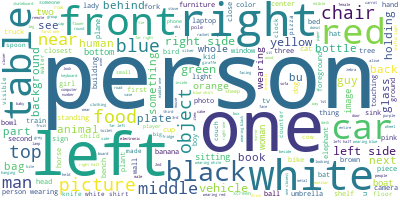

In [4]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [5]:
vectorizer = CountVectorizer()
omatrix = vectorizer.fit_transform(questions)

In [6]:
print('Count Vectorizer: ----')
print(len(vectorizer.get_feature_names()))
print(omatrix.toarray().shape)

print('Stanza: ----')
print(len(new_doc.sentences))
print(new_doc.num_words)
print(new_doc.num_tokens)

Count Vectorizer: ----
5016
(120319, 5016)
Stanza: ----
120649
705421
705421


In [7]:
print('question:' ,' '.join([w.text for w in new_doc.sentences[0].words]))
for (w1, rel, w2) in new_doc.sentences[0].dependencies:
    print('({}, {}, {})'.format(w1.text, rel, w2.text))

question: is it an bear ?
(bear, cop, is)
(bear, nsubj, it)
(bear, det, an)
(ROOT, root, bear)
(bear, punct, ?)


Show the word dependency for each word in the sentence

In [8]:
for w in new_doc.sentences[0].words:
    print(w.id, w.text, '\t: (', w.deprel, w.head, ')')

1 is 	: ( cop 4 )
2 it 	: ( nsubj 4 )
3 an 	: ( det 4 )
4 bear 	: ( root 0 )
5 ? 	: ( punct 4 )


## 3) Create vocab and dependency triplets

I will keep only the vocabulary with the feature names extracted with the CountVectorizer as it already removes punctiation and stopwords.

In [9]:
vocab = {_w: {'id':i, 'contexts':[], 'occurrence':[]} for i, _w in enumerate(vectorizer.get_feature_names())}
context_vocab = {}

for sent in tqdm(new_doc.sentences):
    words = {word.id:word.text for word in sent.words}
    words[0] = 'ROOT'
    triplets = [(w1.text, rel, w2.text) for (w1, rel, w2) in sent.dependencies]
    for word in sent.words:
        if not (word.text in vocab.keys()):
            continue
        # Compute the dependecy for this word
        # triplets will be (word, word.rel, word.head) as seen above
        dependency = (word.deprel, words[word.head])
        if not (dependency in context_vocab.keys()):
            context_vocab[dependency] = [word.text]
        else:
            context_vocab[dependency].append(word.text)

        if not (dependency in vocab[word.text]["contexts"]):
            vocab[word.text]["contexts"].append(dependency)
            vocab[word.text]["occurrence"].append(1)
        else:
            i = vocab[word.text]["contexts"].index(dependency)
            vocab[word.text]["occurrence"][i] += 1

100%|████████████████████████████████| 120649/120649 [00:12<00:00, 9436.34it/s]


Keep all context that has more than 10 ocurrences

In [10]:
context_ocurrence = np.array([len(context_vocab[k]) for k in context_vocab])
keeping = np.where(context_ocurrence > 10)
relevant_context = np.asarray(list(context_vocab.keys()))[keeping]
len(relevant_context)

3257

Vectorization

In [11]:
shape = (len(vocab), len(relevant_context))
feat_matrix = np.zeros(shape)

for w in tqdm(list(vocab.values())):
    i = w['id']
    context = w['contexts']
    ocurrence = w['occurrence']
    for j, dep in enumerate(relevant_context):
        try:
            k = context.index(tuple(dep))
        except ValueError:
            continue
        feat_matrix[i,j] = ocurrence[k]

100%|██████████████████████████████████████| 5016/5016 [01:26<00:00, 57.96it/s]


In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
reduced_feat_matrix = svd.fit_transform(feat_matrix)

In [13]:
y_pred = KMeans(n_clusters=5).fit_predict(reduced_feat_matrix)

In [14]:
from sklearn.manifold import TSNE
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(reduced_feat_matrix)

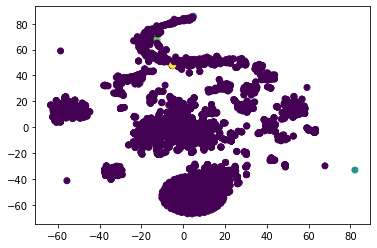

In [15]:
import matplotlib.pyplot as plt
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)

## 4) Using only ocurrence